In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb#

import pickle
import joblib

plt.rcParams['figure.figsize'] = (14, 12)


import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("data/chrun_modeling_fe.csv", index_col=[0])
X = df.drop("exited", axis=1)
y = df["exited"]

In [3]:
def create_X_y(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y

def scale(scaler, X_train, X_test):
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test
    
def train_test(data, target, test_size, scaler):
    #Separate between Features and Target
    X, y = create_X_y(data, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    #Scale the data
    X_train, X_test = scale(scaler, X_train, X_test)
    #print the shapes
    print("Shapes after the split     ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

def create_model(model, name,  data, target, test_size, scaler): # model, name, data, target, test_size, scaler
    X_train, X_test, y_train, y_test = train_test(data, target, test_size, scaler)
    m = model()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    df = pd.DataFrame(
        {"models": [name],
        "accuracy": [accuracy_score(y_test, y_pred)],
        "precision_score": [precision_score(y_test, y_pred)],
        "f1_score": [f1_score(y_test, y_pred)],
        "recall_score": [recall_score(y_test, y_pred)]
        })

    #print("Accuracy Score             ", accuracy_score(y_test, y_pred))
    #print("Classification Report \n", classification_report(y_test, y_pred))

    # __, ax = plt.subplots(figsize=(10, 10))
    # plot_confusion_matrix(m, X_test, y_test, ax=ax)
    # plt.title(f"{name} Confussion Matrix ", fontdict={"fontsize": 15});
    return m, df



In [4]:
models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier, GradientBoostingClassifier, svm]

In [5]:
model, df_1 = create_model(LogisticRegression, "Logistic Regression", df, "exited", .2, StandardScaler)
model, df_2 = create_model(DecisionTreeClassifier, "Decision Tree Classifier", df, "exited", .2, StandardScaler)
model, df_3 = create_model(RandomForestClassifier, "Random Forest Classifier", df, "exited", .2, StandardScaler)
model, df_4 = create_model(KNeighborsClassifier, "KNeighborsClassifier", df, "exited", .2, StandardScaler)
model, df_5 = create_model(GradientBoostingClassifier, "GradientBoostingClassifier", df, "exited", .2, StandardScaler)
model, df_6 = create_model(svm.SVC, "svm", df, "exited", .2, StandardScaler)

Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)
Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)
Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)
Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)
Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)
Shapes after the split      (8000, 13) (2000, 13) (8000,) (2000,)


In [6]:
models_df = pd.concat([df_1,df_2,df_3,df_4, df_5,df_6])
models_df

,models,accuracy,precision_score,f1_score,recall_score
0,Logistic Regression,0.8430,0.690821,0.476667,0.363868
0,Decision Tree Classifier,0.7795,0.446667,0.476868,0.511450
0,Random Forest Classifier,0.8665,0.760331,0.579528,0.468193
0,KNeighborsClassifier,0.8390,0.630037,0.516517,0.437659
0,GradientBoostingClassifier,0.8650,0.745020,0.580745,0.475827
0,svm,0.8575,0.775510,0.516129,0.386768


---
## Handling the imblance in the dataset
- four Different approaches of balancing
---

In [7]:
def balancing(method, X, y):
    X, y = method().fit_resample(X,y)
    #print(y.value_counts())
    return X, y

def create_X_y(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y

def scale(scaler, X_train, X_test):
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test
    
def train_test(data, target, test_size, scaler, balance_method):
    #Separate between Features and Target
    X, y = create_X_y(data, target)
    #Balancing
    X, y = balancing(balance_method, X, y)
    #print(X.shape, y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    #Scale the data
    X_train, X_test = scale(scaler, X_train, X_test)
    #print the shapes
    #print("Shapes after the split     ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

def create_model(model, name,  data, target, test_size, scaler, balance_method, balance_name): # model, name, data, target, test_size, scaler
    X_train, X_test, y_train, y_test = train_test(data, target, test_size, scaler, balance_method)
    m = model()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    df = pd.DataFrame(
        {"models": [name],
        f"accuracy_{balance_name}": [accuracy_score(y_test, y_pred)],
        #f"precision_score {balance_name}": [precision_score(y_test, y_pred)],
        f"f1_score_{balance_name}": [f1_score(y_test, y_pred)],
        #f"recall_score {balance_name}": [recall_score(y_test, y_pred)]
        })

    #print("Accuracy Score             ", accuracy_score(y_test, y_pred))
    #print("Classification Report \n", classification_report(y_test, y_pred))

    # __, ax = plt.subplots(figsize=(10, 10))
    # plot_confusion_matrix(m, X_test, y_test, ax=ax)
    # plt.title(f"{name} Confussion Matrix ", fontdict={"fontsize": 15});
    return m, df



In [8]:
model, df_1_sm = create_model(LogisticRegression, "Logistic Regression", df, "exited", .2, StandardScaler, SMOTE, "smote")
model, df_2_sm = create_model(DecisionTreeClassifier, "Decision Tree Classifier", df, "exited", .2, StandardScaler, SMOTE, "smote")
model, df_3_sm = create_model(RandomForestClassifier, "Random Forest Classifier", df, "exited", .2, StandardScaler,  SMOTE, "smote")
model, df_4_sm = create_model(KNeighborsClassifier, "KNeighborsClassifier", df, "exited", .2, StandardScaler,  SMOTE, "smote")
model, df_5_sm = create_model(GradientBoostingClassifier, "GradientBoostingClassifier", df, "exited", .2, StandardScaler,  SMOTE, "smote")
model, df_6_sm = create_model(svm.SVC, "svm", df, "exited", .2, StandardScaler,  SMOTE, "smote")

models_df_sm = pd.concat([df_1_sm,df_2_sm,df_3_sm,df_4_sm, df_5_sm,df_6_sm])


In [9]:
model, df_1_ad = create_model(LogisticRegression, "Logistic Regression", df, "exited", .2, StandardScaler, ADASYN, "adasyn")
model, df_2_ad = create_model(DecisionTreeClassifier, "Decision Tree Classifier", df, "exited", .2, StandardScaler, ADASYN, "adasyn")
model, df_3_ad = create_model(RandomForestClassifier, "Random Forest Classifier", df, "exited", .2, StandardScaler,  ADASYN, "adasyn")
model, df_4_ad = create_model(KNeighborsClassifier, "KNeighborsClassifier", df, "exited", .2, StandardScaler,  ADASYN, "adasyn")
model, df_5_ad = create_model(GradientBoostingClassifier, "GradientBoostingClassifier", df, "exited", .2, StandardScaler,  ADASYN, "adasyn")
model, df_6_ad = create_model(svm.SVC, "svm", df, "exited", .2, StandardScaler,  ADASYN, "adasyn")

models_df_ad = pd.concat([df_1_ad,df_2_ad,df_3_ad,df_4_ad, df_5_ad,df_6_ad])


In [10]:
model, df_1_smt = create_model(LogisticRegression, "Logistic Regression", df, "exited", .2, StandardScaler, SMOTETomek, "smotetomek")
model, df_2_smt = create_model(DecisionTreeClassifier, "Decision Tree Classifier", df, "exited", .2, StandardScaler, SMOTETomek, "smotetomek")
model, df_3_smt = create_model(RandomForestClassifier, "Random Forest Classifier", df, "exited", .2, StandardScaler,  SMOTETomek, "smotetomek")
model, df_4_smt = create_model(KNeighborsClassifier, "KNeighborsClassifier", df, "exited", .2, StandardScaler,  SMOTETomek, "smotetomek")
model, df_5_smt = create_model(GradientBoostingClassifier, "GradientBoostingClassifier", df, "exited", .2, StandardScaler,  SMOTETomek, "smotetomek")
model, df_6_smt = create_model(svm.SVC, "svm", df, "exited", .2, StandardScaler,  SMOTETomek, "smotetomek")

models_df_smt = pd.concat([df_1_smt,df_2_smt,df_3_smt,df_4_smt, df_5_smt,df_6_smt])


In [11]:
model, df_1_sme = create_model(LogisticRegression, "Logistic Regression", df, "exited", .2, StandardScaler, SMOTEENN, "smoteenn")
model, df_2_sme = create_model(DecisionTreeClassifier, "Decision Tree Classifier", df, "exited", .2, StandardScaler, SMOTEENN, "smoteenn")
model, df_3_sme = create_model(RandomForestClassifier, "Random Forest Classifier", df, "exited", .2, StandardScaler,  SMOTEENN, "smoteenn")
model, df_4_sme = create_model(KNeighborsClassifier, "KNeighborsClassifier", df, "exited", .2, StandardScaler,  SMOTEENN, "smoteenn")
model, df_5_sme = create_model(GradientBoostingClassifier, "GradientBoostingClassifier", df, "exited", .2, StandardScaler,  SMOTEENN, "smoteenn")
model, df_6_sme = create_model(svm.SVC, "svm", df, "exited", .2, StandardScaler,  SMOTEENN, "smoteenn")

models_df_sme = pd.concat([df_1_sme,df_2_sme,df_3_sme,df_4_sme, df_5_sme,df_6_sme])


In [12]:
dfs = [models_df_sm, models_df_ad, models_df_smt, models_df_sme]
dfs = [df.set_index('models') for df in dfs]
dfs = dfs[0].join(dfs[1:])

In [13]:
dfs.reset_index(inplace=True)

In [14]:
dfs

,models,accuracy_smote,f1_score_smote,accuracy_adasyn,f1_score_adasyn,accuracy_smotetomek,f1_score_smotetomek,accuracy_smoteenn,f1_score_smoteenn
0,Logistic Regression,0.834589,0.834329,0.827478,0.829193,0.827259,0.829004,0.843606,0.860481
1,Decision Tree Classifier,0.806026,0.802808,0.806775,0.810695,0.809524,0.811917,0.821456,0.838531
2,Random Forest Classifier,0.877903,0.875520,0.871079,0.870795,0.859206,0.859206,0.877473,0.890847
3,KNeighborsClassifier,0.844319,0.845000,0.840652,0.843016,0.843273,0.843102,0.844512,0.859890
4,GradientBoostingClassifier,0.849027,0.844789,0.856336,0.855975,0.856110,0.856731,0.866359,0.880000
5,svm,0.849655,0.847888,0.852258,0.853042,0.840131,0.839253,0.851767,0.865318


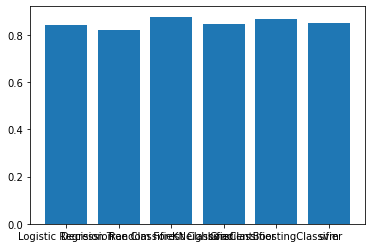

In [15]:
plt.bar(dfs.models, dfs.accuracy_smoteenn);

### Conclusion
After analysing different models and different balancing approaches we can conclude that Random Forest as model is the best fit and the best balancing is made with SMOTEEN

---
# Hyperparameter Optimization
---


In [16]:
X_train, X_test, y_train, y_test = train_test(df, "exited", .2, StandardScaler,  SMOTEENN)

In [17]:
param_grid = { 
    "n_estimators": [200, 500, 800],
    "criterion" :["gini", "entropy"],
    "max_depth" : [7,8,10,12],
    "min_samples_leaf" : [4,6,8,10]
    
}

rfc = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_params = rf_grid.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 12,
 'min_samples_leaf': 4,
 'n_estimators': 800}

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       573
           1       0.87      0.89      0.88       718

    accuracy                           0.87      1291
   macro avg       0.87      0.86      0.86      1291
weighted avg       0.87      0.87      0.87      1291



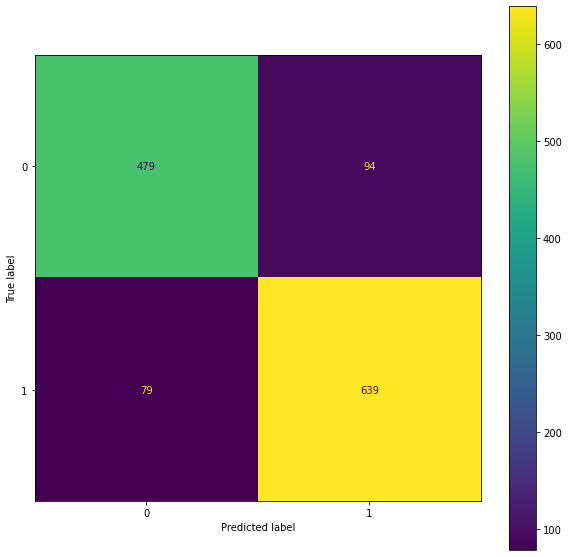

In [18]:
rf_model_gcv = RandomForestClassifier(random_state=42, criterion="gini", max_depth=12, max_features="auto", min_samples_leaf=4, n_estimators=800)

rf_model_gcv.fit(X_train, y_train)

y_pred = rf_model_gcv.predict(X_test)

print(classification_report(y_test, y_pred))

__, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf_model_gcv, X_test, y_test, ax=ax);

# Export the model

In [20]:
joblib.dump(rf_model_gcv, "models/bank_churn_model")

['models/bank_churn_model']